In [1]:
import os

import cv2
import numpy as np
import skimage.morphology

import metaimage
import display

%load_ext autoreload
%autoreload 2

c:\Users\sutto\anaconda3\envs\compvis\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


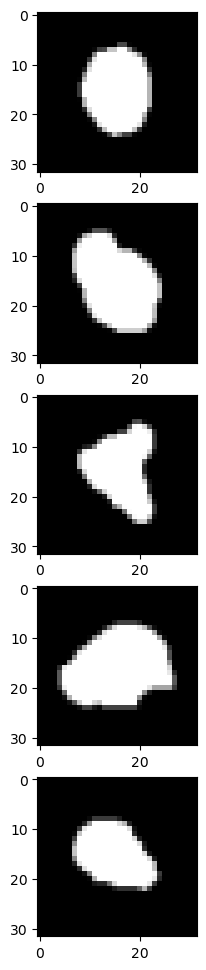

In [34]:
raw_mask_folder = "images/bbbc039/raw_masks"

mask_files = os.listdir(raw_mask_folder)

def extract_masks_from_file(file_path: str, image_side_length: int) -> np.ndarray:
    example_mask = cv2.imread(
        file_path, cv2.IMREAD_UNCHANGED
    )[:, :, 2]

    example_mask = skimage.morphology.label(example_mask)

    masks = []

    max_dim = 0

    for mask_value in range(1, example_mask.max() + 1):
        cur_mask = np.zeros_like(example_mask, dtype=np.uint8)
        cur_mask[example_mask == mask_value] = 255

        bounding_box = cv2.boundingRect(cur_mask)

        if mask_is_on_edge(cur_mask, bounding_box):
            continue

        cur_mask = cur_mask[
            bounding_box[1] : bounding_box[1] + bounding_box[3],
            bounding_box[0] : bounding_box[0] + bounding_box[2],
        ]
        
        if cur_mask.shape[0] > max_dim or cur_mask.shape[1] > max_dim:
            max_dim = max(cur_mask.shape[0], cur_mask.shape[1])

        masks.append(cur_mask)

    max_dim = int(max_dim * 1.25)

    resized_masks = []

    for mask in masks:
        cur_mask = np.zeros((max_dim, max_dim), dtype=np.uint8)
        mask_x = (max_dim - mask.shape[1]) // 2
        mask_y = (max_dim - mask.shape[0]) // 2
        
        cur_mask[
            mask_y : mask_y + mask.shape[0],
            mask_x : mask_x + mask.shape[1],
        ] = mask
        
        cur_mask = cv2.resize(cur_mask, (image_side_length, image_side_length), interpolation=cv2.INTER_AREA)
        
        resized_masks.append(cur_mask)

    resized_masks = np.array(resized_masks)
    
    return resized_masks

def mask_is_on_edge(cur_mask, bounding_box):
    return (
            bounding_box[1] == 0
            or bounding_box[0] == 0
            or bounding_box[1] + bounding_box[3] == cur_mask.shape[0]
            or bounding_box[0] + bounding_box[2] == cur_mask.shape[1]
        )

bboxes = extract_masks_from_file(os.path.join(raw_mask_folder, mask_files[0]), 32)

display.grid(bboxes[:5])
display.show()

In [2]:
if not os.path.exists("images/bbbc039/masks"):
    os.makedirs("images/bbbc039/masks")

n_masks = 0
cur_file = 0

while n_masks < 5000:
    file_path = os.path.join(raw_mask_folder, mask_files[cur_file])
    
    bboxes = extract_masks_from_file(file_path, 32)
    
    for mask in bboxes:
        cv2.imwrite(f"images/bbbc039/masks/{n_masks}.png", mask)
        n_masks += 1
    
    cur_file += 1

NameError: name 'raw_mask_folder' is not defined

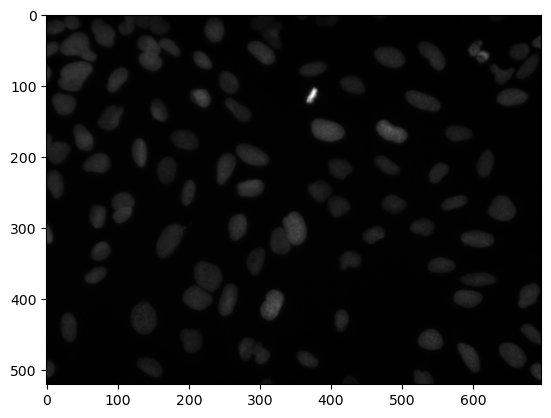

In [4]:
raw_image_folder = "images/bbbc039/raw"

image_files = os.listdir(raw_image_folder)

example_image = cv2.imread(os.path.join(raw_image_folder, image_files[0]), cv2.IMREAD_UNCHANGED)

example_image = metaimage.Mask.from_array(example_image)

example_image.plot()
display.show()

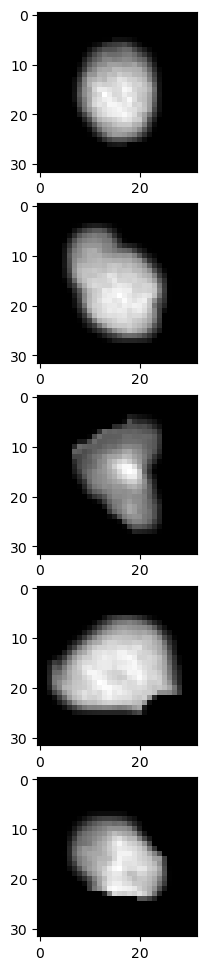

In [2]:
raw_mask_folder = "images/bbbc039/raw_masks"
raw_image_folder = "images/bbbc039/raw"

mask_files = os.listdir(raw_mask_folder)
image_files = os.listdir(raw_image_folder)

mask_files = os.listdir(raw_mask_folder)

def extract_cell_images_from_file(image_file_path: str, mask_file_path: str, image_side_length: int) -> np.ndarray:
    image = cv2.imread(
        image_file_path, cv2.IMREAD_UNCHANGED
    )
    
    mask = cv2.imread(
        mask_file_path, cv2.IMREAD_UNCHANGED
    )[:, :, 2]

    mask = skimage.morphology.label(mask)

    masks = []

    max_dim = 0

    for mask_value in range(1, mask.max() + 1):
        cur_mask = np.zeros_like(mask, dtype=np.uint8)
        cur_image = np.ones_like(mask, dtype=np.float32) * image.min()
        cur_mask[mask == mask_value] = 1
        
        cur_mask = cv2.dilate(cur_mask, np.ones((5, 5), dtype=np.uint8), iterations=1)
        
        cur_image[cur_mask == 1] = image[cur_mask == 1]

        bounding_box = cv2.boundingRect(cur_mask)

        if mask_is_on_edge(cur_mask, bounding_box):
            continue

        cur_image = cur_image[
            bounding_box[1] : bounding_box[1] + bounding_box[3],
            bounding_box[0] : bounding_box[0] + bounding_box[2],
        ]
        
        if cur_image.shape[0] > max_dim or cur_image.shape[1] > max_dim:
            max_dim = max(cur_image.shape[0], cur_image.shape[1])

        masks.append(cur_image)

    max_dim = int(max_dim * 1.1)

    resized_masks = []

    for mask in masks:
        cur_mask = np.ones((max_dim, max_dim), dtype=np.float32) * image.min()
        mask_x = (max_dim - mask.shape[1]) // 2
        mask_y = (max_dim - mask.shape[0]) // 2
        
        cur_mask[
            mask_y : mask_y + mask.shape[0],
            mask_x : mask_x + mask.shape[1],
        ] = mask
        
        cur_mask = cv2.resize(cur_mask, (image_side_length, image_side_length), interpolation=cv2.INTER_AREA)
        
        cur_mask = 255 * (cur_mask - cur_mask.min()) / (cur_mask.max() - cur_mask.min())
        
        cur_mask = cur_mask.astype(np.uint8)
        
        resized_masks.append(cur_mask)

    resized_masks = np.array(resized_masks)
    
    return resized_masks

def mask_is_on_edge(cur_mask, bounding_box):
    return (
            bounding_box[1] == 0
            or bounding_box[0] == 0
            or bounding_box[1] + bounding_box[3] == cur_mask.shape[0]
            or bounding_box[0] + bounding_box[2] == cur_mask.shape[1]
        )

bboxes = extract_cell_images_from_file(
    os.path.join(raw_image_folder, image_files[0]),
    os.path.join(raw_mask_folder, mask_files[0]),
    32
)

display.grid(bboxes[:5])

display.show()

In [54]:
if not os.path.exists("images/bbbc039/images"):
    os.makedirs("images/bbbc039/images")

n_masks = 0
cur_file = 0

while n_masks < 5000:
    file_path = os.path.join(raw_mask_folder, mask_files[cur_file])
    
    bboxes = extract_cell_images_from_file(
        os.path.join(raw_image_folder, image_files[cur_file]),
        os.path.join(raw_mask_folder, mask_files[cur_file]),
    48,
    )
    
    for mask in bboxes:
        cv2.imwrite(f"images/bbbc039/images/{n_masks}.png", mask)
        n_masks += 1
    
    cur_file += 1